<h3 style="text-align: center;"><b>Полносвязные и свёрточные нейронные сети</b></h3>

Потренируемся в построении нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.

## Imports

In [3]:
%%capture
!pip install catalyst torchsummary

In [5]:
import numpy as np
import os
import requests
from tqdm.autonotebook import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catalyst.utils import set_global_seed

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tfs
from torchmetrics import Accuracy

from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

import cv2

# dataset
from sklearn.datasets import make_moons
from torchvision.datasets import MNIST

sns.set(style="darkgrid", font_scale=1.4)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [7]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

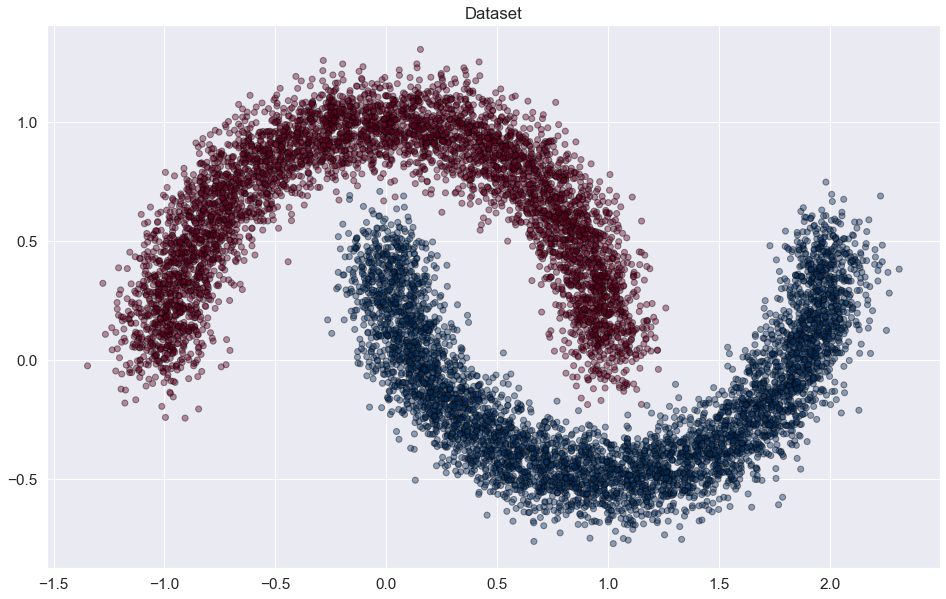

In [8]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu", alpha=.42, ec='black')
plt.show()

Сделаем train/test split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [10]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

assert X_train_t.shape[0] == y_train_t.shape[0], 'Проверьте формы выборок'
assert X_val_t.shape[0] == y_val_t.shape[0], 'Проверьте формы выборок'

Создаем `Dataset` и `DataLoader`. 

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**

Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Напишем модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте использовать коробочное решение мы не будем). После чего инициализируем веса нормальным распределением (`torch.randn`).

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weights = nn.Parameter(torch.randn((in_features, out_features),
                                                requires_grad=True))
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features), requires_grad=True)

    def forward(self, x):
        x = x @ self.weights 
        if self.bias:
            x += self.bias_term
        return x

In [13]:
# задаем модель
linear_regression = LinearRegression(2, 1)

# задаем функцию потерь
loss_function = nn.BCEWithLogitsLoss() # BCE на логитах, так как не пропустили через сигмоиду

# задаем оптимизатор
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [14]:
params = list(linear_regression.parameters())
print(params)
print('____________________________________________________________')
print(f'В получившейся модели - {len(params)} обучаемых гиперпараметра (-ов) и {len(params) + 1} обучаемых параметра (-ов)')

[Parameter containing:
tensor([[-0.7635],
        [ 0.7663]], requires_grad=True), Parameter containing:
tensor([1.], requires_grad=True)]
____________________________________________________________
В получившейся модели - 2 обучаемых гиперпараметра (-ов) и 3 обучаемых параметра (-ов)


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [15]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in tqdm(range(max_epochs)):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch).view(-1)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

  1%|          | 1/100 [00:00<00:19,  4.95it/s]

Iteration: 0
Batch accuracy: 0.2421875


  3%|▎         | 3/100 [00:00<00:15,  6.37it/s]

Iteration: 100
Batch accuracy: 0.8125


  4%|▍         | 4/100 [00:00<00:15,  6.20it/s]

Iteration: 200
Batch accuracy: 0.84375


  6%|▌         | 6/100 [00:00<00:13,  6.75it/s]

Iteration: 300
Batch accuracy: 0.90625


  7%|▋         | 7/100 [00:01<00:15,  5.97it/s]

Iteration: 400
Batch accuracy: 0.890625


  9%|▉         | 9/100 [00:01<00:18,  4.95it/s]

Iteration: 500
Batch accuracy: 0.8984375


 11%|█         | 11/100 [00:02<00:17,  5.00it/s]

Iteration: 600
Batch accuracy: 0.859375


 12%|█▏        | 12/100 [00:02<00:16,  5.30it/s]

Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [54]:
best = 759
print(f'Потребовалось {best} итераций, чтобы алгоритм сошелся')

Потребовалось 759 итераций, чтобы алгоритм сошелся


### Визуализируем результаты

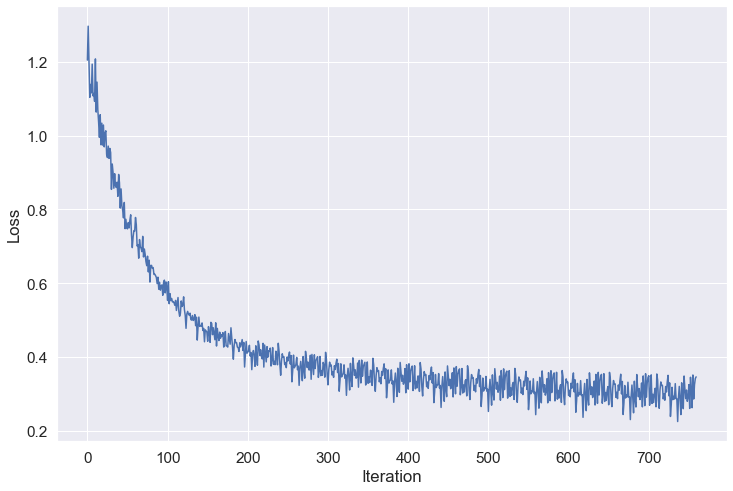

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

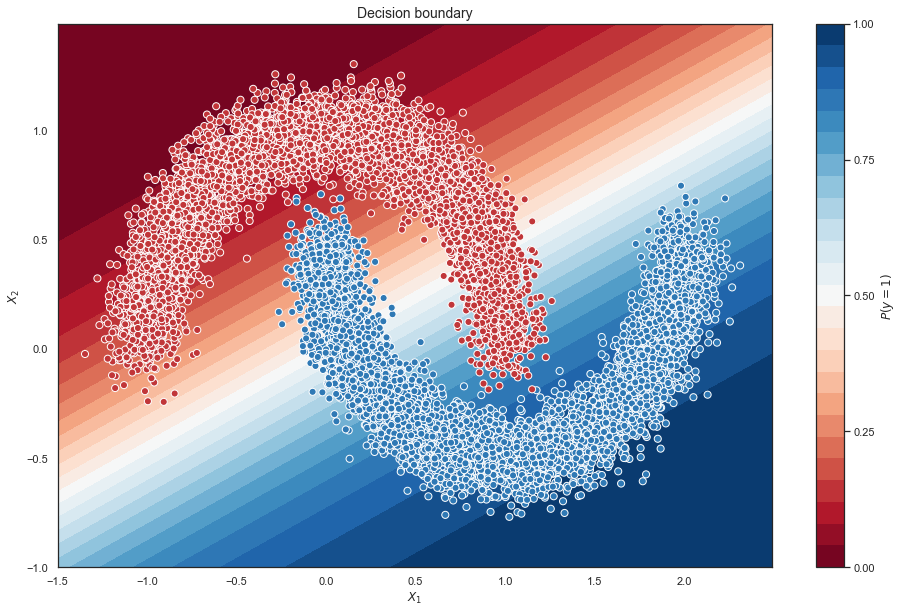

In [18]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

Реализуем predict и посчитаем accuracy на test

In [19]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = linear_regression(x_batch)
        probabilities = 1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [20]:
y_pred = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val_t, y_pred)

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [21]:
print(f'Accuracy после обучения: {accuracy}')

Accuracy после обучения: 0.866


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы.

In [22]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

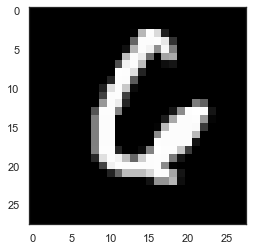

In [23]:
x_batch, y_batch = next(iter(train_dataloader))
plt.imshow(x_batch[0].numpy().squeeze(), cmap='gray');

In [24]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Зададим лосс для обучения (кросс-энтропия).

In [25]:
activation = nn.ELU()

input_size = 784
first_layer = 128
hidden_sizes = [128, 128]
output_size = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, first_layer),
    activation,
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    activation,
    nn.Linear(hidden_sizes[1], output_size)
)

In [26]:
summary(model, (input_size,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [28]:
max_epochs = 10
accuracy_elu = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum(dim=0)
            all = len(preds) 
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        acc = round(epoch_correct/epoch_all, 5)
        print(f"Loader: {k}. Accuracy: {acc}")
        accuracy_elu[k].append(acc)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8898


 10%|█         | 1/10 [00:39<05:52, 39.14s/it]

Loader: valid. Accuracy: 0.9421
Epoch: 2
Loader: train. Accuracy: 0.94933


 20%|██        | 2/10 [01:14<04:53, 36.64s/it]

Loader: valid. Accuracy: 0.9552
Epoch: 3
Loader: train. Accuracy: 0.9631


 30%|███       | 3/10 [01:43<03:52, 33.25s/it]

Loader: valid. Accuracy: 0.9646
Epoch: 4
Loader: train. Accuracy: 0.97038


 40%|████      | 4/10 [02:11<03:06, 31.11s/it]

Loader: valid. Accuracy: 0.9702
Epoch: 5
Loader: train. Accuracy: 0.97695


 50%|█████     | 5/10 [02:47<02:44, 32.87s/it]

Loader: valid. Accuracy: 0.9732
Epoch: 6
Loader: train. Accuracy: 0.9788


 60%|██████    | 6/10 [03:40<02:39, 39.92s/it]

Loader: valid. Accuracy: 0.9712
Epoch: 7
Loader: train. Accuracy: 0.98182


 70%|███████   | 7/10 [04:32<02:11, 43.82s/it]

Loader: valid. Accuracy: 0.9727
Epoch: 8
Loader: train. Accuracy: 0.9836


 80%|████████  | 8/10 [05:07<01:22, 41.08s/it]

Loader: valid. Accuracy: 0.9774
Epoch: 9
Loader: train. Accuracy: 0.9861


 90%|█████████ | 9/10 [05:37<00:37, 37.50s/it]

Loader: valid. Accuracy: 0.9763
Epoch: 10
Loader: train. Accuracy: 0.98648


100%|██████████| 10/10 [06:03<00:00, 36.36s/it]

Loader: valid. Accuracy: 0.9788


#### Класс модели без nn.Sequential
Перепишем цикл обучения выше не используя nn.Sequential.

In [29]:
in_features = 784
first_layer = 128
hidden_sizes = [128, 128]
out_features = 10

# создадим класс простой NN через pytorch
class SimpleNN(nn.Module):
    # first required method
    def __init__(self, in_features, out_features):
        super().__init__()

        # layers
        self.flatten = nn.Flatten()
        self.linear_0 = self.make_layer(in_features, 128)
        self.linear_1 = self.make_layer(128, 128)
        self.linear_2 = self.make_layer(128, out_features)
        self.activation = F.elu
    
    def make_layer(self, in_f, out_f):
        '''Method for easy creation of layers'''
        return nn.Linear(in_f, out_f)

    # second required method
    def forward(self, x):
        '''Forward propogation'''
        x = self.flatten(x)
        # input layer
        x = self.linear_0(x)
        x = self.activation(x)

        # first layer
        x = self.linear_1(x)
        x = self.activation(x)

        # out layer
        x = self.linear_2(x)
        return x

In [30]:
# cuda/cpu
print(f"Using {DEVICE} device")

# model
model = SimpleNN(in_features, out_features)

# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters())

# data loaders
loaders = {"train": train_dataloader, "valid": valid_dataloader}

# metric
accuracy = Accuracy('multiclass', num_classes=10).to(DEVICE)

Using cpu device


In [31]:
# вспомогательные списки
# лосс на каждой итерации
loss_train = []
# общий лосс
total_loss = []
# accuracy
acc_val = []
# общее количество эпох
MAX_EPOCHS = 10
# цикл обучения
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
    # для каждой части датасета
    for iteration, (X_batch, y_batch) in enumerate(train_dataloader):
        # ЭТАП ОБУЧЕНИЕ
        # переводим модель в режим обучения
        model.train()
        # обнуляем градиенты у оптимизатора
        optimizer.zero_grad()
        # пропускаем данные через модель
        outputs = model(X_batch.to(DEVICE))
        # выравниваем выходы в одномерный тензор
        outputs = outputs#.view(-1)
        # считаем лосс
        loss = criterion(outputs, y_batch)
        # backward
        loss.backward()
        # собираем лоссы
        loss_train.append(loss.detach().cpu().numpy().item())
        # делаем шаг оптимизатора
        optimizer.step()
    # собираем средний лосс
    total_loss.append(np.mean(loss_train))
    
    # ЭТАП ВАЛИДАЦИИ
    for iteration, (X_batch, y_batch) in enumerate(valid_dataloader):
    # режим инференса или валидации, тестирования
        model.eval()
        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            outputs = outputs#.view(-1)
            loss = criterion(outputs, y_batch.to(DEVICE))
            # считаем вероятности
            proba = torch.sigmoid(outputs)
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
            acc_val.append(batch_acc.detach().cpu().numpy().item())

100%|██████████| 10/10 [04:03<00:00, 24.33s/it]


In [32]:
acc = np.mean(acc_val)
print(f"Accuracy полносвязной нейронной сети {acc:.2%}")

Accuracy полносвязной нейронной сети 96.70%


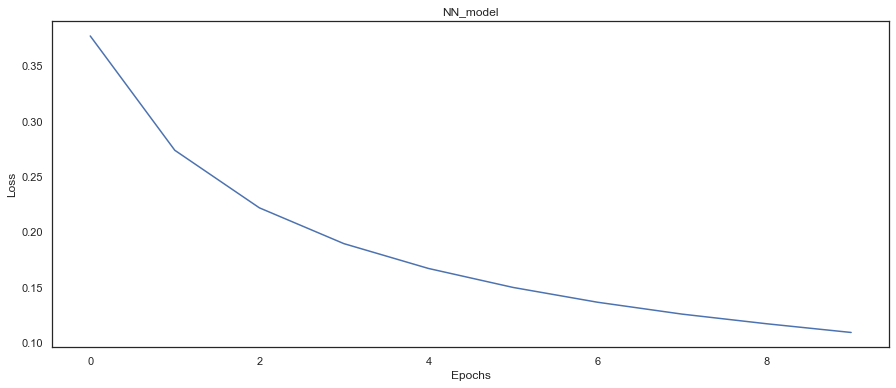

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("NN_model")
plt.show()

#### Обучение и валидация функциями

Вместо цикла, подготовим две функции, для удобства работы с моделью.

In [34]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in valid_dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(valid_dataloader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'
              .format(test_loss, correct, len(valid_dataloader.dataset),
                      100. * correct / len(valid_dataloader.dataset)))
        acc = 100. * correct / len(valid_dataloader.dataset)
        return acc

In [35]:
total_acc = []
for epoch in tqdm(range(1, 10 + 1)):
    train(epoch)
    epoch_acc = test()
    total_acc.append(epoch_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.007181


 10%|█         | 1/10 [00:30<04:31, 30.17s/it]


Test set: Average loss: 0.0007, Accuracy: 9748/10000 (97.4800%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023326


 20%|██        | 2/10 [00:54<03:35, 26.95s/it]


Test set: Average loss: 0.0007, Accuracy: 9747/10000 (97.4700%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.055697


 30%|███       | 3/10 [01:18<02:57, 25.38s/it]


Test set: Average loss: 0.0006, Accuracy: 9776/10000 (97.7600%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010983


 40%|████      | 4/10 [01:45<02:35, 25.91s/it]


Test set: Average loss: 0.0007, Accuracy: 9772/10000 (97.7200%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.012258


 50%|█████     | 5/10 [02:13<02:14, 26.96s/it]


Test set: Average loss: 0.0006, Accuracy: 9801/10000 (98.0100%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.005414


 60%|██████    | 6/10 [02:38<01:44, 26.17s/it]


Test set: Average loss: 0.0007, Accuracy: 9783/10000 (97.8300%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.021717


 70%|███████   | 7/10 [03:03<01:17, 25.77s/it]


Test set: Average loss: 0.0007, Accuracy: 9791/10000 (97.9100%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001555


 80%|████████  | 8/10 [03:32<00:53, 26.66s/it]


Test set: Average loss: 0.0007, Accuracy: 9781/10000 (97.8100%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001006


 90%|█████████ | 9/10 [03:56<00:25, 25.99s/it]


Test set: Average loss: 0.0007, Accuracy: 9789/10000 (97.8900%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.003505


100%|██████████| 10/10 [04:23<00:00, 26.34s/it]


Test set: Average loss: 0.0008, Accuracy: 9756/10000 (97.5600%)



In [36]:
acc = np.mean(total_acc)
print(f"Accuracy полносвязной нейронной сети {acc:.2f}%")

Accuracy полносвязной нейронной сети 97.74%


### Протестируем разные функции активации
Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy. Реализуем это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [37]:
def test_activation_function(activation):
    print(f'Вычисляю Accuracy для {activation}. Ожидайте...')
    criterion = torch.nn.CrossEntropyLoss()
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    input_size = 784
    first_layer = 128
    hidden_sizes = [128, 128]
    output_size = 10

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, first_layer),
        activation,
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        activation,
        nn.Linear(hidden_sizes[1], output_size),
    )

    optimizer = torch.optim.Adam(model.parameters())

    model.to(DEVICE)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        epoch_correct = 0
        epoch_all = 0
        set_global_seed(42 + epoch)
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum(dim=0)
                all =  len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()


            acc = round(epoch_correct/epoch_all, 5)
            accuracy[k].append(acc)

    return accuracy["valid"]

In [38]:
elu_accuracy = accuracy_elu["valid"]
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.1))

Вычисляю Accuracy для Identical(). Ожидайте...


100%|██████████| 10/10 [04:03<00:00, 24.40s/it]


Вычисляю Accuracy для ReLU(). Ожидайте...


100%|██████████| 10/10 [03:57<00:00, 23.75s/it]


Вычисляю Accuracy для LeakyReLU(negative_slope=0.1). Ожидайте...


100%|██████████| 10/10 [03:47<00:00, 22.74s/it]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

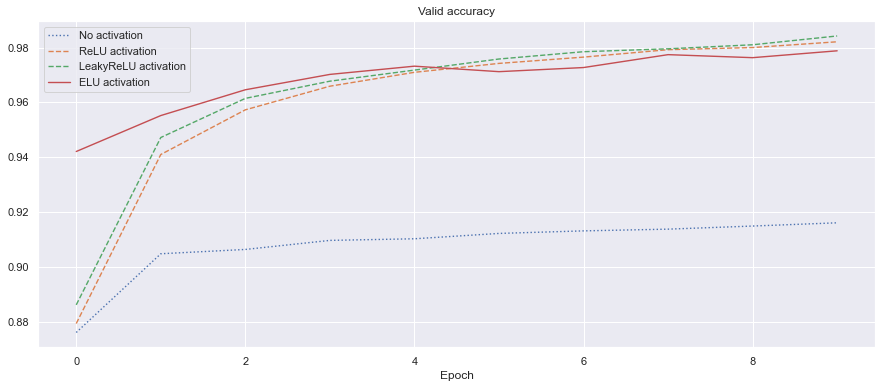

In [39]:
sns.set(style="darkgrid")
max_epochs=10
plt.figure(figsize=(15, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), 
         plain_accuracy, 
         label="No activation", 
         linewidth=1.4,
         linestyle='dotted'
         )
plt.plot(range(max_epochs), 
         relu_accuracy, 
         label="ReLU activation", 
         linewidth=1.4,
         linestyle='dashed'
         )
plt.plot(range(max_epochs), 
         leaky_relu_accuracy, 
         label="LeakyReLU activation", 
         linewidth=1.4,
         linestyle='--'
         )
plt.plot(range(max_epochs), 
         elu_accuracy, 
         label="ELU activation", 
         linewidth=1.4,
         linestyle='solid'
         )
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [40]:
the_best = nn.ELU()
print(f'Наивысший accuracy к концу обучения показала {the_best}')

Наивысший accuracy к концу обучения показала ELU(alpha=1.0)


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [41]:
%%capture
# метод для google colab
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [42]:
# метод для локальной среды
url = "https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg"
r = requests.get(url)
with open("sample_photo.jpg", "wb") as f:
    f.write(r.content)

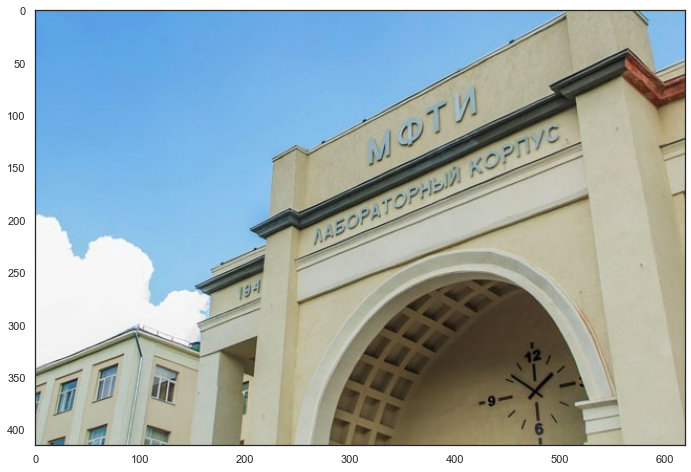

In [43]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуем посмотреть как различные свертки влияют на фото. Например: 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

In [44]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

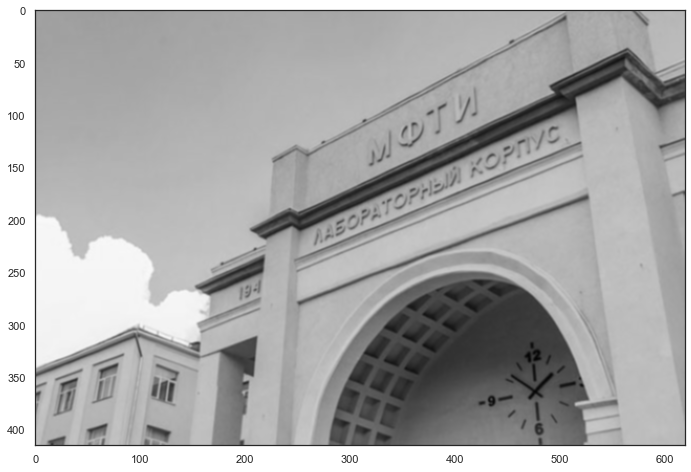

In [45]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставим для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

In [46]:
quest = [1, 2, 3, 4, 5, 6]
var = ['Е', 'Д', 'А', 'В', 'Б', 'Г']
print(f'{quest[0]}: {var[0]}, {quest[1]}: {var[1]}, '
      f'{quest[2]}: {var[2]}, {quest[3]}: {var[3]}, '
      f'{quest[4]}: {var[4]}, {quest[5]}: {var[5]}')

1: Е, 2: Д, 3: А, 4: В, 5: Б, 6: Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуем архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используем модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.

In [47]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
model = LeNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [49]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Задание. Обучим CNN
Используем код обучения, который мы написали для полносвязной нейронной сети.

In [50]:
max_epochs = 10
accuracy = {'train': [], 'valid': []}
for epoch in tqdm(range(max_epochs)):
    set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum(dim=0)
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == 'train':
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == 'train':
            print(f'Epoch: {epoch+1}')
        acc = round(epoch_correct/epoch_all, 5)
        print(f'Loader: {k}. Accuracy: {acc}')
        accuracy[k].append(acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.88397


 10%|█         | 1/10 [00:25<03:53, 25.91s/it]

Loader: valid. Accuracy: 0.9715
Epoch: 2
Loader: train. Accuracy: 0.9704


 20%|██        | 2/10 [00:51<03:27, 25.96s/it]

Loader: valid. Accuracy: 0.9794
Epoch: 3
Loader: train. Accuracy: 0.97875


 30%|███       | 3/10 [01:19<03:06, 26.66s/it]

Loader: valid. Accuracy: 0.9798
Epoch: 4
Loader: train. Accuracy: 0.98347


 40%|████      | 4/10 [01:45<02:38, 26.47s/it]

Loader: valid. Accuracy: 0.9854
Epoch: 5
Loader: train. Accuracy: 0.98657


 50%|█████     | 5/10 [02:13<02:14, 26.85s/it]

Loader: valid. Accuracy: 0.9865
Epoch: 6
Loader: train. Accuracy: 0.98818


 60%|██████    | 6/10 [02:41<01:50, 27.54s/it]

Loader: valid. Accuracy: 0.9862
Epoch: 7
Loader: train. Accuracy: 0.98972


 70%|███████   | 7/10 [03:09<01:22, 27.46s/it]

Loader: valid. Accuracy: 0.9877
Epoch: 8
Loader: train. Accuracy: 0.9907


 80%|████████  | 8/10 [03:38<00:55, 27.96s/it]

Loader: valid. Accuracy: 0.9859
Epoch: 9
Loader: train. Accuracy: 0.99273


 90%|█████████ | 9/10 [04:07<00:28, 28.22s/it]

Loader: valid. Accuracy: 0.9885
Epoch: 10
Loader: train. Accuracy: 0.9933


100%|██████████| 10/10 [04:32<00:00, 27.30s/it]

Loader: valid. Accuracy: 0.9848


In [51]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

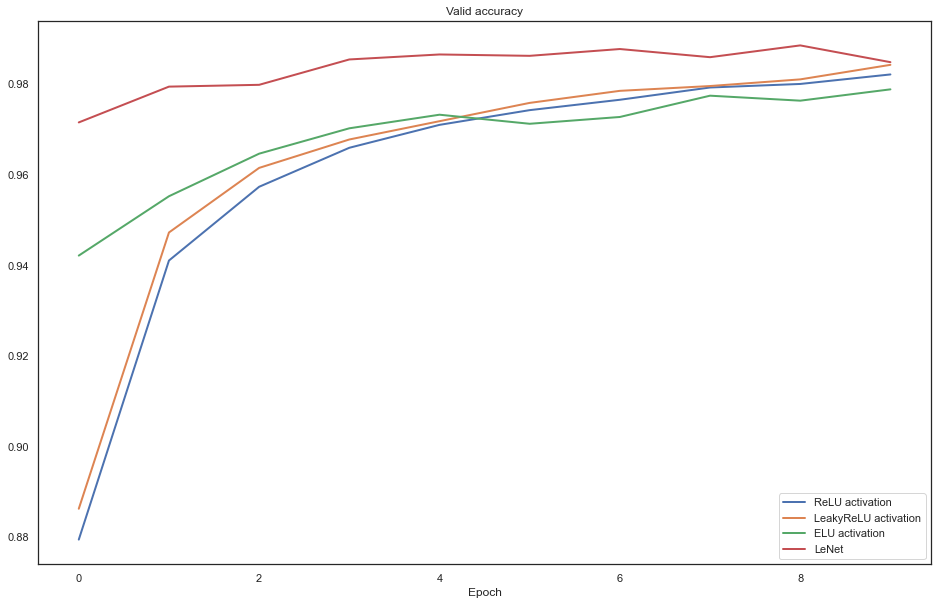

In [52]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [53]:
acc = round(max(lenet_accuracy), 2)
print(f'LeNet Accuracy послу обучения составляет {acc}')

LeNet Accuracy послу обучения составляет 0.99
